# Simple Neural Network Load Forecast
This notebook creates a simple neural network model that forecasts next-day hourly loads. We pull load data from the Energy Information Administration's (EIA's) API and weather data from Open-Meteo's API and then train and test the model.

## 1. Paste in your EIA API Key
A key is required to access data through the EIA API, and instructions on registering for a key are available on the 
<a href="https://www.eia.gov/opendata/">EIA Open Data webpage</a>. This notebook won't run unless a valid key has been pasted into the spot below:

In [1]:
# paste in your key from EIA with quotation marks
key = ''

In [2]:
# import libraries needed
from datetime import datetime, timedelta
import math
import requests
import json
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 2. Make the EIA API Request
We set up our parameters for the GET request from the EIA API. In this example, we are looking for historical hourly load data for a selected Balancing Authority (BA).

In [3]:
# function to get EIA API data and put in dataframe
# this function gets a little complicated because EIA limits pull to 5000 observations,
# so we take the user's date range and break into sub-ranges, pulls data for each sub-range
# and then put all the data together
def eiaPull(BA,start_dt,end_dt):
    # the EIA API limits us to 5000 observations at a time, so we split up API call into 180 days each
    strt_dt_fmt = datetime.strptime(start_dt,'%Y-%m-%d').date() # make into date format
    end_dt_fmt = datetime.strptime(end_dt,'%Y-%m-%d').date()
    eia_days = max(0,(end_dt_fmt - strt_dt_fmt).days + 1) # number of days being pulled
    eia_pulls = min(10,math.ceil(eia_days/180)) # number of pulls have to make (no more than 180 days at a time) but limit to 10 pulls total
    strt_dt_fmt_i = strt_dt_fmt
    res_ls = [] # make empty list to store temp dfs
    eia_url='https://api.eia.gov/v2/electricity/rto/region-data/data/'
    # iterate through dates and pull data
    for i in np.arange(1,eia_pulls+1):
        #set up date range for pull
        end_dt_fmt_i = strt_dt_fmt_i + timedelta(days=min((end_dt_fmt - strt_dt_fmt_i).days,179))
        # define params
        eia_api_params = {'frequency':'hourly','data[0]':'value',
                  'facets[respondent][]':BA,
                  'facets[type][]':['D'],
                  'start':datetime.strftime(strt_dt_fmt_i,"%Y-%m-%d")+"T00",
                  'end':datetime.strftime(end_dt_fmt_i,"%Y-%m-%d")+"T23",
                  'sort[0][column]':'period',
                  'sort[0][direction]':'asc','offset':'0'}
        eia_api_params['api_key'] = key
        # make request
        r_eia = requests.get(eia_url,params=eia_api_params,timeout=20)
        eia_results = json.loads(r_eia.text) # convert to dict
        print('Pulling',BA,'data for',strt_dt_fmt_i, 'to', end_dt_fmt_i, 'gave status code',r_eia.status_code)
        res_df = pd.DataFrame(eia_results["response"]["data"])
        res_df = res_df[['period','value']] # select desired columns
        res_ls.append(res_df) # put temp dfs into list
        strt_dt_fmt_i = end_dt_fmt_i + timedelta(days=1)
        # end for loop
    #clean up dataframe
        res_all_df = pd.concat(res_ls) # concatenate into one dataframe
        res_all_df['period'] = pd.to_datetime(res_all_df['period'],utc=True) #make datetime
        res_all_df['value'] = pd.to_numeric(res_all_df['value']) #make numeric
        res_all_df = res_all_df.rename(columns={'period':'DateTime','value':'Load'})
    return res_all_df

In [4]:
# pull data for selected BA, start date, and end date (do no more than 4 years of data)
eia_df = eiaPull('PGE','2021-07-01','2024-06-30')

Pulling PGE data for 2021-07-01 to 2021-12-27 gave status code 200
Pulling PGE data for 2021-12-28 to 2022-06-25 gave status code 200
Pulling PGE data for 2022-06-26 to 2022-12-22 gave status code 200
Pulling PGE data for 2022-12-23 to 2023-06-20 gave status code 200
Pulling PGE data for 2023-06-21 to 2023-12-17 gave status code 200
Pulling PGE data for 2023-12-18 to 2024-06-14 gave status code 200
Pulling PGE data for 2024-06-15 to 2024-06-30 gave status code 200


## 3. Make the Open-Meteo API Request
Get hourly weather data from Open-Meteo. We pull ambient dry bulb temperature, dew point, cloud cover, and wind speed.

In [5]:
# set up and make API GET request- lat and long are for Portland International Airport
wthr_url='https://archive-api.open-meteo.com/v1/era5?'
wthr_api_params = {'latitude':45.5883,'longitude':-122.5944,
              'start_date':'2021-07-01',
              'end_date':'2024-06-30',
              'hourly':['temperature_2m', 'dew_point_2m',
                        'cloud_cover', 'wind_speed_10m']}
# make request
r_wthr = requests.get(wthr_url,params=wthr_api_params,timeout=20)
print(r_wthr.status_code) # make sure request is ok- should return 200

200


In [6]:
# convert results to a dataframe and clean up data
results_wthr = json.loads(r_wthr.text) # convert to dict
wthr_df = pd.DataFrame(results_wthr["hourly"])
wthr_df.info() # check columns and data types
wthr_df['time'] = pd.to_datetime(wthr_df['time'],utc=True) #make datetime
def cel_to_fah(x): return x*(9/5) + 32 # convert to fahrenheit
wthr_df[['temperature_2m', 'dew_point_2m']] = wthr_df[['temperature_2m', 'dew_point_2m']].apply(cel_to_fah)
wthr_df = wthr_df.rename(columns={'time':'DateTime'})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            26304 non-null  object 
 1   temperature_2m  26304 non-null  float64
 2   dew_point_2m    26304 non-null  float64
 3   cloud_cover     26304 non-null  int64  
 4   wind_speed_10m  26304 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.0+ MB


## Data Exploration

In [7]:
# join load data with weather data 
load_df = pd.merge(eia_df,wthr_df, on='DateTime', how='left')
#convert to local time
load_df['DateTime'] = load_df['DateTime'].dt.tz_convert('America/Los_Angeles')
load_df['HE'] = load_df['DateTime'].dt.hour+1
load_df['Day_of_Week'] = load_df['DateTime'].dt.day_name()
load_df['Month'] = load_df['DateTime'].dt.month
load_df['Season'] = np.where(load_df['Month'].isin([12,1,2]), 'Winter',
                             np.where(load_df['Month'].isin([3,4,5]), 'Spring',
                             np.where(load_df['Month'].isin([6,7,8]), 'Summer',
                             'Fall')))
load_df.describe()

,Load,temperature_2m,dew_point_2m,cloud_cover,wind_speed_10m,HE,Month
count,26300.000000,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000,26303.000000
mean,2540.576008,53.441043,44.846011,55.039881,9.945789,12.499449,6.522640
std,420.616608,14.224218,9.772748,40.725623,6.290107,6.922251,3.449133
min,1692.000000,5.360000,-2.920000,0.000000,0.000000,1.000000,1.000000
25%,2241.000000,42.980000,38.300000,10.000000,5.400000,6.500000,4.000000
50%,2504.000000,51.620000,45.500000,60.000000,8.200000,12.000000,7.000000
75%,2813.000000,62.060000,52.520000,100.000000,13.400000,18.000000,10.000000
max,4504.000000,107.060000,73.760000,100.000000,46.400000,24.000000,12.000000


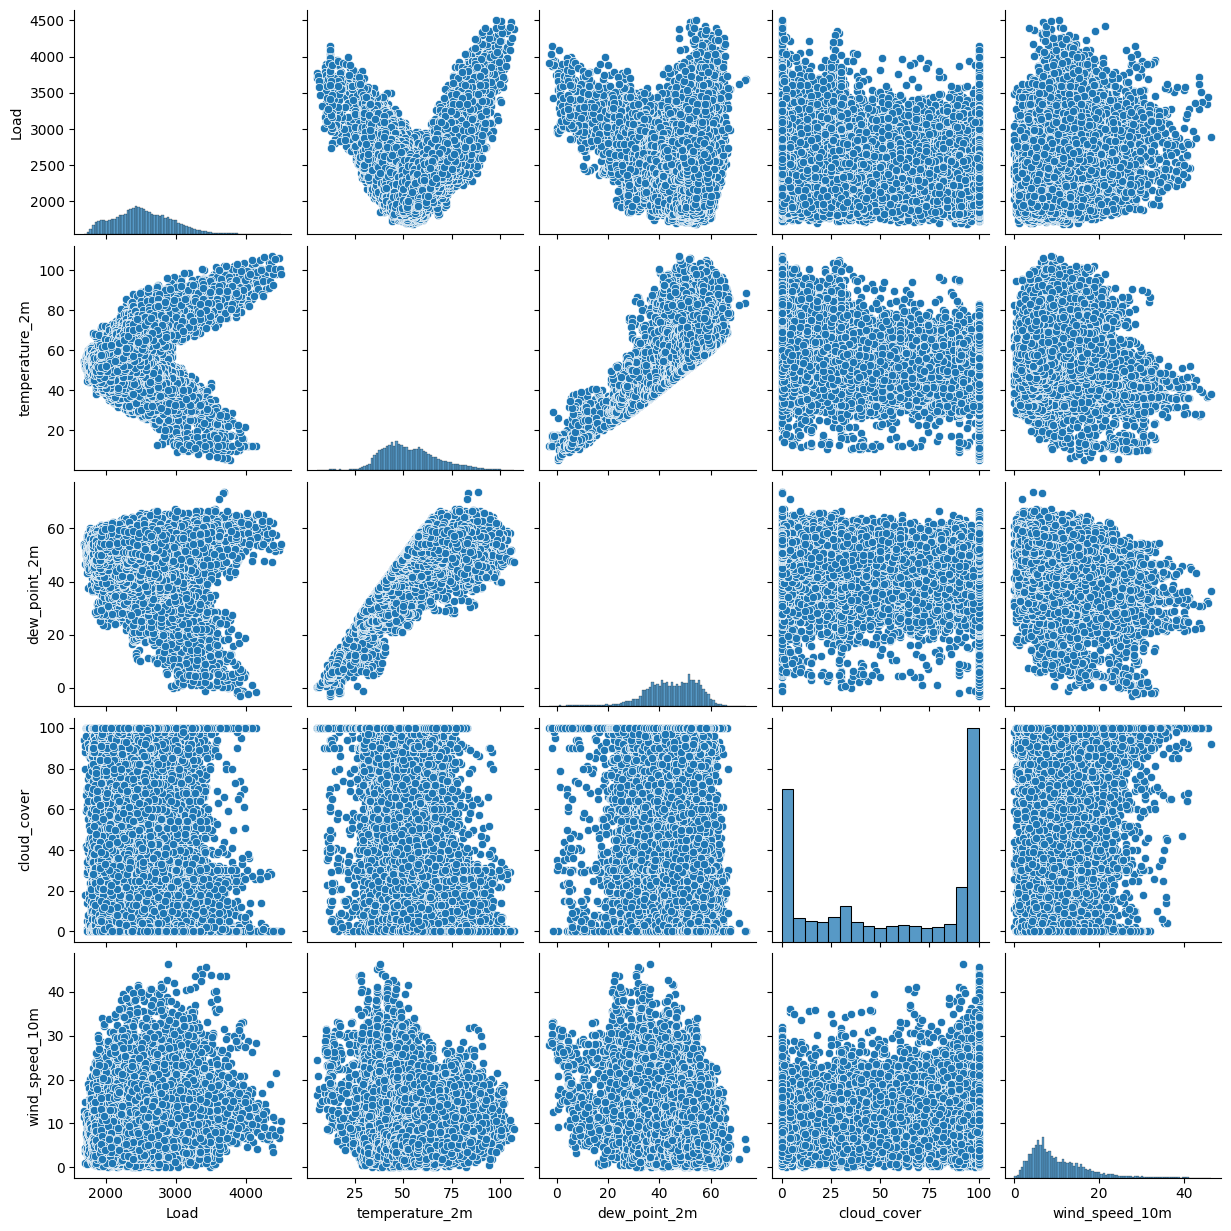

In [110]:
# review correlations
sns.pairplot(load_df[['Load','temperature_2m','dew_point_2m','cloud_cover','wind_speed_10m']])

<Axes: title={'center': 'Daily Load Shape by Day of Week'}, xlabel='Hour Ending', ylabel='MW'>

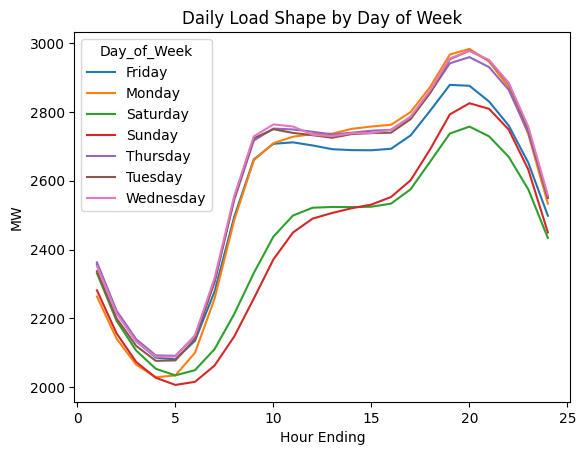

In [8]:
# daily load patterns
# by day of week
dow_avg = load_df.groupby(['HE','Day_of_Week'])['Load'].mean()
dow_avg.unstack().plot(title='Daily Load Shape by Day of Week', xlabel='Hour Ending',
                      ylabel='MW')

<Axes: title={'center': 'Daily Load Shape by Season'}, xlabel='Hour Ending', ylabel='MW'>

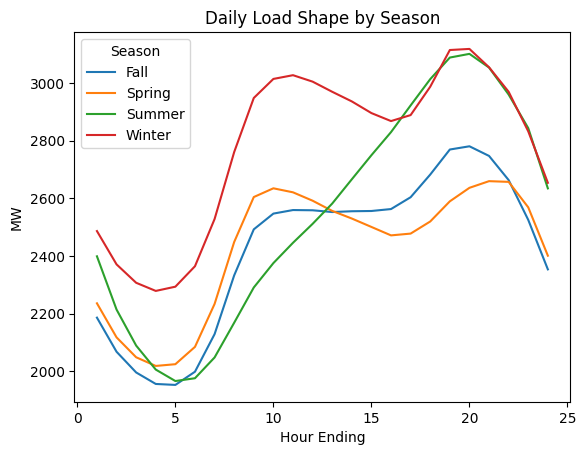

In [9]:
# by season
season_avg = load_df.groupby(['HE','Season'])['Load'].mean()
season_avg.unstack().plot(title='Daily Load Shape by Season', xlabel='Hour Ending',
                      ylabel='MW')

## Model Building

### Split data into training and test sets

In [10]:
## create additional variables for the model
load_df['Load_D2'] = load_df['Load'].shift(48) # op day - 2 because when we make forecast we don't know D-1
load_df['Load_Roll'] = load_df['Load'].rolling(48).mean().shift(24) #rolling avg load lagged
load_df['Load_W1'] = load_df['Load'].shift(168) #op day - 7
load_df['Temperature_Roll'] = load_df['temperature_2m'].rolling(24).mean().shift(48) #rolling avg temp lagged
day_dumbs = pd.get_dummies(load_df['Day_of_Week'],dtype=int) # day of week dummies
HE_dumbs = pd.get_dummies(load_df['HE'],prefix='HE',dtype=int) # hour ending dummies
load_df = pd.concat([load_df,day_dumbs,HE_dumbs],axis=1) # append columns
# make dummies into -1 and 1 values (instead of 0 and 1)
load_df['Date'] = pd.to_datetime(load_df['DateTime']).dt.date
load_df.head()

,DateTime,Load,temperature_2m,dew_point_2m,cloud_cover,wind_speed_10m,HE,Day_of_Week,Month,Season,...,HE_16,HE_17,HE_18,HE_19,HE_20,HE_21,HE_22,HE_23,HE_24,Date
0,2021-06-30 17:00:00-07:00,2936.0,76.28,58.82,91,8.7,18,Wednesday,6,Summer,...,0,0,1,0,0,0,0,0,0,2021-06-30
1,2021-06-30 18:00:00-07:00,2968.0,76.64,59.00,91,8.0,19,Wednesday,6,Summer,...,0,0,0,1,0,0,0,0,0,2021-06-30
2,2021-06-30 19:00:00-07:00,2933.0,73.40,59.90,90,14.5,20,Wednesday,6,Summer,...,0,0,0,0,1,0,0,0,0,2021-06-30
3,2021-06-30 20:00:00-07:00,2844.0,70.34,58.46,91,16.7,21,Wednesday,6,Summer,...,0,0,0,0,0,1,0,0,0,2021-06-30
4,2021-06-30 21:00:00-07:00,2772.0,69.44,57.20,95,14.6,22,Wednesday,6,Summer,...,0,0,0,0,0,0,1,0,0,2021-06-30


In [11]:
## create additional variables for the model
load_df['Load_D2'] = load_df['Load'].shift(48) # op day - 2 because when we make forecast we don't know D-1
load_df['Load_Roll'] = load_df['Load'].rolling(48).mean().shift(24) #rolling avg load lagged
load_df['Load_W1'] = load_df['Load'].shift(168) #op day - 7
load_df['Temperature_Roll'] = load_df['temperature_2m'].rolling(24).mean().shift(48) #rolling avg temp lagged
day_dumbs = pd.get_dummies(load_df['Day_of_Week'],dtype=int) # day of week dummies
HE_dumbs = pd.get_dummies(load_df['HE'],prefix='HE',dtype=int) # hour ending dummies
load_df = pd.concat([load_df,day_dumbs,HE_dumbs],axis=1) # append columns
# make dummies into -1 and 1 values (instead of 0 and 1)
load_df[['Sunday','Monday', 'Tuesday', 'Wednesday','Thursday','Friday', 'Saturday']].map(lambda x : x if(x==1) else x-1) 
load_df[['HE_1','HE_2','HE_3','HE_4','HE_5','HE_6','HE_7','HE_8','HE_9','HE_10',
            'HE_11','HE_12','HE_13','HE_14','HE_15','HE_16','HE_17','HE_18','HE_19',
            'HE_20','HE_21','HE_22','HE_23','HE_24']].map(lambda x : x if(x==1) else x-1) 
load_df['Date'] = pd.to_datetime(load_df['DateTime']).dt.date
# add in all holidays
hol = holidays.US(years=[2021,2022,2023,2024])
hol_Xmas1 = list({i for i in hol if (hol[i]=='Christmas Day') | (hol[i]=='Christmas Day (observed)')})
hol_Xmas2 = [d+timedelta(days=1) for d in hol_Xmas1]
hol_Xmas = hol_Xmas1 = hol_Xmas2
hol_Thnx1 = list({i for i in hol if hol[i]=='Thanksgiving'})
hol_Thnx2 = [d+timedelta(days=1) for d in hol_Thnx1]
hol_Thnx = hol_Thnx1 + hol_Thnx2
hol_NY = list({i for i in hol if hol[i]=="New Year's Day"})
load_df['Holiday'] = np.where((load_df['Date'].isin(hol)) & 
                              (load_df['Date'].isin(hol_Xmas+hol_Thnx+hol_NY)==False),1,-1)
load_df['Thanksgiving'] = np.where(load_df['Date'].isin(hol_Thnx),1,-1)
load_df['Christmas'] = np.where(load_df['Date'].isin(hol_Xmas),1,-1)
load_df['NewYears'] = np.where(load_df['Date'].isin(hol_NY),1,-1)

load_df = load_df.dropna() # drop those with NaN to avoid error
# train/test dates
train_start = '2021-07-15 00:00:00+00:00'
train_end = '2023-10-31 23:00:00+00:00'
test_start = '2023-11-01 00:00:00+00:00'
test_end = '2024-03-01 00:00:00+00:00'
# features to include
feat_cont = ['temperature_2m', 'dew_point_2m', 'cloud_cover','wind_speed_10m','Load_D2','Load_Roll','Temperature_Roll','Load_W1']
feat_cat = ['Sunday','Monday', 'Tuesday', 'Wednesday','Thursday','Friday', 'Saturday',
            'HE_1','HE_2','HE_3','HE_4','HE_5','HE_6','HE_7','HE_8','HE_9','HE_10',
            'HE_11','HE_12','HE_13','HE_14','HE_15','HE_16','HE_17','HE_18','HE_19','HE_20','HE_21','HE_22','HE_23','HE_24',
            'Holiday','Thanksgiving','Christmas','NewYears']
load_df[feat_cont].astype(float)
# train and test sets
train_set = load_df.loc[(load_df['DateTime'] > train_start) & (load_df['DateTime'] <= train_end)]
test_set = load_df.loc[(load_df['DateTime'] >= test_start ) & (load_df['DateTime'] <= test_end)]
y_train = train_set['Load']
y_test = test_set['Load']
X_train = train_set[np.concatenate([feat_cont,feat_cat])].astype(float)
X_test = test_set[np.concatenate([feat_cont,feat_cat])].astype(float)
#scale data
scaler = StandardScaler() #remove mean and scale to unit variance
scaler_X = scaler.fit(X_train.loc[:,feat_cont].astype(float)) # fit to calc mean and stdev
X_train.loc[:,feat_cont] = scaler_X.transform(X_train[feat_cont]) # transform data
X_test.loc[:,feat_cont] = scaler_X.transform(X_test[feat_cont])
scaler_y = scaler.fit(y_train.to_frame())
y_train = scaler_y.transform(y_train.to_frame()).ravel()
y_test = scaler_y.transform(y_test.to_frame()).ravel()

### Define and run model

In [15]:
# set up multilayer preception model
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV
mlp = MLPRegressor(hidden_layer_sizes=(30,30), # (30,30) is two layers, each with 30 neurons
                   activation='relu', #relu,tanh,identity,logistic
                   solver='adam', #lbfgs,sgd,adam
                   alpha=0.0001, #0.0001
                   #learning_rate='constant' #only if sgd
                   beta_1=0.9, #0.9
                   beta_2=0.999,
                   shuffle=True,
                   warm_start=True,
                   max_iter=1000,
                   random_state=1)
#grid search for parameters
params = {'hidden_layer_sizes':[(20),(30),(40),(50),(20,20),(30,30),(40,40),(50,50),(20,20,20),(30,30,30),(40,40,40),(50,50,50)],
          'activation' : ['relu', 'tanh'],
          'alpha':10.0 ** -np.arange(1, 7)}
mlp_grd = GridSearchCV(estimator=mlp, param_grid=params, 
                       scoring='neg_mean_squared_error',refit=True,
                       cv=5)

In [16]:
# fit model and get predicted values + rmse
nn = mlp_grd.fit(X_train,y_train)

In [17]:
print('Best Parameters:', nn.best_params_)
print('Best Score:',nn.best_score_)

Best Parameters: {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (40, 40)}
Best Score: -0.04345374697530313


## Evaluate Results on Test Set
Note that in practice we have forecasted weather data and not actuals, so the forecast errors here will be smaller than reality.

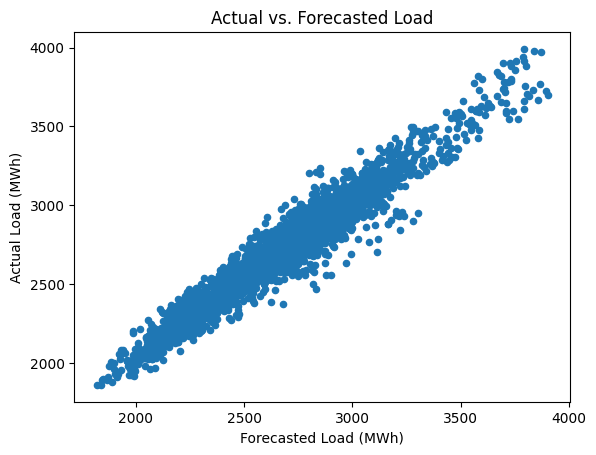

In [18]:
# add forecast and forecast error to test data 
y_pred = nn.predict(X_test)
test_set = test_set.assign(Load_Forecast = scaler_y.inverse_transform(y_pred.reshape(-1,1)))
test_set.loc[:,'MWh_Error'] = test_set['Load_Forecast'] - test_set['Load']
test_set.loc[:,'Pct_Error'] = test_set['Load_Forecast']/test_set['Load']-1
act_fcst = test_set.plot.scatter(x='Load_Forecast',y='Load',title='Actual vs. Forecasted Load')
act_fcst.set_xlabel('Forecasted Load (MWh)')
act_fcst.set_ylabel('Actual Load (MWh)')
plt.show()

MAPE: 2.79 %


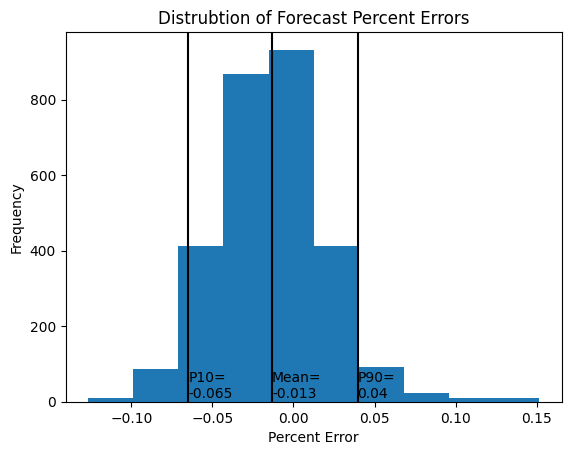

In [19]:
# show MAPE
print("MAPE:",round(np.mean(abs(test_set['Pct_Error'])),4)*100,"%")
# plot distribution of errors 
hist_error = test_set.plot(column=['Pct_Error'], kind='hist',legend=False,
                  title='Distrubtion of Forecast Percent Errors',
                  xlabel='Percent Error')
mean_pct_error = test_set['Pct_Error'].mean()
pct_error_ptcl5 = test_set['Pct_Error'].quantile(0.05)
pct_error_ptcl95 = test_set['Pct_Error'].quantile(0.95)
plt.axvline(x=mean_pct_error,color='black')
plt.axvline(x=pct_error_ptcl5,color='black')
plt.axvline(x=pct_error_ptcl95,color='black')
plt.text(mean_pct_error,10,'Mean=\n'+str(round(mean_pct_error,3)))
plt.text(pct_error_ptcl5,10,'P10=\n'+str(round(pct_error_ptcl5,3)))
plt.text(pct_error_ptcl95,10,'P90=\n'+str(round(pct_error_ptcl95,3)))
plt.show(hist_error)

Text(0, 0.5, 'Percent Error')

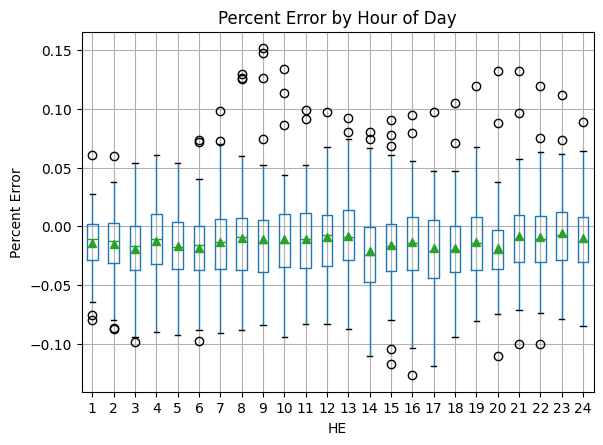

In [20]:
# plot forecast error by hour of day
he_error = test_set.boxplot(column=['Pct_Error'], by='HE', showmeans=True)
he_error.get_figure().suptitle('')
he_error.set_title('Percent Error by Hour of Day')
he_error.set_ylabel('Percent Error')

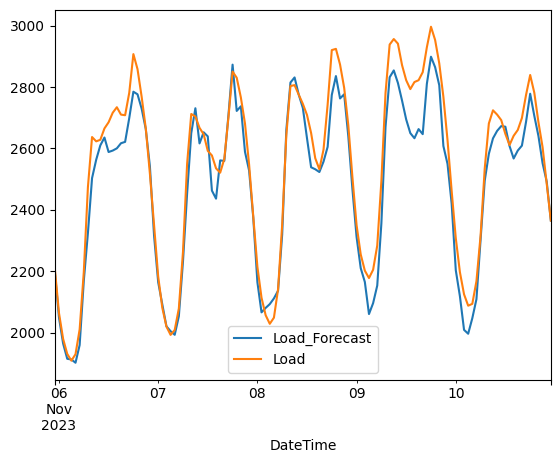

In [21]:
fcst_df = test_set.loc[(test_set['DateTime'] >= '2023-11-06 00:00:00-07:00') & (test_set['DateTime'] <= '2023-11-11 00:00:00-07:00')]
fcst_plt = fcst_df.plot(x="DateTime",y=['Load_Forecast','Load'], kind='line',)
plt.show(fcst_plt)